In [1]:
#!pip install keras-tuner
#!pip install --upgrade tensorflow

import os
import pandas as pd
import geopandas as gpd
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import numpy as np
np.bool = np.bool_
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
#from kerastuner import HyperModel, RandomSearch
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, mean_squared_error, r2_score, mean_absolute_error

from tensorflow.keras.models import load_model
import seaborn as sns
from shapely.geometry import Point
import re
import random

#!pip install gluonts
#!pip install mxnet
#!pip install --upgrade mxnet == 1.6
#!pip install "gluonts[torch]"

# support for mxnet models, faster datasets
#!pip install gluonts[mxnet,pro]

# support for torch models, faster datasets
#!pip install gluonts[torch,pro]

#!pip install mxnet -f https://dist.mxnet.io/python/cpu

from gluonts.dataset.pandas import PandasDataset, is_uniform, infer_freq
from gluonts.dataset.split import split
from gluonts.mx import DeepAREstimator, Trainer
from gluonts.evaluation import make_evaluation_predictions, Evaluator

random.seed(42)

In [2]:
# Define a function to compute evaluation metrics
def compute_metrics(y_true, y_pred):
    metrics = {}
    metrics['MSE'] = mean_squared_error(y_true, y_pred)
    metrics['RMSE'] = np.sqrt(metrics['MSE'])
    metrics['MAE'] = mean_absolute_error(y_true, y_pred)
    
    # Handling division by zero in MAPE calculation
    nonzero_indices = y_true != 0
    if np.any(nonzero_indices):
        metrics['MAPE'] = np.mean(np.abs((y_true[nonzero_indices] - y_pred[nonzero_indices]) / y_true[nonzero_indices])) * 100
    else:
        metrics['MAPE'] = np.inf  # Assign a value for cases where all true values are zero
    
    return metrics

In [3]:
folder_path = '/Users/tab/Documents/R/MScA/2024/Capstone Project'

# List of files
files = [
    'start_demand_daily.csv',
    'end_demand_daily.csv'
]

# Function to read a file and print its columns
def print_column_names(file_path):
    if file_path.endswith('.csv'):
        df = pd.read_csv(file_path)
    elif file_path.endswith('.xlsx'):
        df = pd.read_excel(file_path)
    else:
        print(f"File format not supported for {file_path}")
        return
    print(f"Columns in {os.path.basename(file_path)}: {df.columns.tolist()}")

# Iterate over the files, read each one, and print column names
for file in files:
    file_path = os.path.join(folder_path, file)
    print_column_names(file_path)

# Trips data
start_demand = pd.read_csv(os.path.join(folder_path, 'start_demand_hourly.csv'))
end_demand = pd.read_csv(os.path.join(folder_path, 'end_demand_hourly.csv'))

Columns in start_demand_daily.csv: ['trip_start', 'Start Community Area Number', 'trip_count', 'bus_stops', 'train_stops', 'Trip Date', 'total_crimes', 'total_population', 'asian_population_percentage', 'black_population_percentage', 'hispanic_population_percentage', 'white_population_percentage', 'other_population_percentage', 'datetime', 'temp', 'precip', 'snow', 'Gas Price', 'median_household_income', 'low_income_percent', 'middle_income_percent', 'high_income_percent', 'not_hs_grad_percent', 'hs_grad_percent', 'some_college_percent', 'has_bachelors_percent', 'hs_grad_or_higher_percent', 'below_poverty_percent']
Columns in end_demand_daily.csv: ['trip_end', 'End Community Area Number', 'trip_count']


In [4]:
# Sort data by time
start_demand.sort_values('trip_start', inplace=True)

# Define the split date
# Train = May 10, 2022 to June 30, 2023
# Test = July 1, 2023 to Sept 29, 2023
train_end_date = '2023-06-30' 

# Split the data
train_data = start_demand[start_demand['trip_start'] <= train_end_date]
test_data = start_demand[start_demand['trip_start'] > train_end_date]

#train_data.to_csv('train_hourly_demand.csv', index=False)
#test_data.to_csv('test_hourly_demand.csv', index=False)

# Printing sizes
print(f"Training set size: {len(train_data)}")
print(f"Test set size: {len(test_data)}")

Training set size: 768768
Test set size: 171864


In [5]:
# List of columns to exclude
exog_vars = ['temp', 'precip', 'snow', 'Gas Price', 'total_crimes']
holdout_vars = ['trip_count', 'Start Community Area Number', 'trip_start', 'datetime', 'Trip Date']

# Get all columns from train_data
all_columns = train_data.columns.tolist()

# Filter out the excluded columns
static_features = [col for col in all_columns if col not in exog_vars]

# Ensure holdout_vars are not included in static_features
for var in holdout_vars:
    if var in static_features:
        static_features.remove(var)

# Create a new dataframe with only the static features
static_df = train_data[static_features]

## Segmenting High and Low Density Community Areas

In [7]:
# Get unique community area numbers from the dataset
community_areas = sorted(test_data['Start Community Area Number'].unique())

# Get unique community area numbers with trip_counts above set threshold
trip_threshold = 90
high_density_community = sorted(test_data[test_data['trip_count'] > trip_threshold]['Start Community Area Number'].unique())

# Compute low_density_community using set operations
high_density_set = set(high_density_community)
low_density_community = sorted(list(set(community_areas) - high_density_set))

In [8]:
high_density_set

{6, 7, 8, 22, 24, 28, 32}

In [9]:
# Convert to datetime variable
train_data.loc[train_data['Start Community Area Number'].isin(high_density_community), 'trip_start'] = pd.to_datetime(train_data['trip_start'])
train_data.loc[train_data['Start Community Area Number'].isin(low_density_community), 'trip_start'] = pd.to_datetime(train_data['trip_start'])
test_data.loc[test_data['Start Community Area Number'].isin(high_density_community), 'trip_start'] = pd.to_datetime(test_data['trip_start'])
test_data.loc[test_data['Start Community Area Number'].isin(low_density_community), 'trip_start'] = pd.to_datetime(test_data['trip_start'])

# Creating high and low density splits for train data
train_data_high_density = train_data[train_data['Start Community Area Number'].isin(high_density_community)]
train_data_low_density = train_data[train_data['Start Community Area Number'].isin(low_density_community)]

# Creating high and low density splits for train data
test_data_high_density = test_data[test_data['Start Community Area Number'].isin(high_density_community)]
test_data_low_density = test_data[test_data['Start Community Area Number'].isin(low_density_community)]

In [10]:
# Create a Gluonts dataset for DeepAR
pd_dataset_train_high_density = PandasDataset.from_long_dataframe(train_data_high_density, target = 'trip_count', 
                                                     freq = 'h', timestamp = 'trip_start',
                                                     static_features = static_df,
                                                     item_id = 'Start Community Area Number')

pd_dataset_train_low_density = PandasDataset.from_long_dataframe(train_data_low_density, target = 'trip_count', 
                                                     freq = 'h', timestamp = 'trip_start',
                                                     static_features = static_df,
                                                     item_id = 'Start Community Area Number')

pd_dataset_test_high_density = PandasDataset.from_long_dataframe(test_data_high_density, 
                                                    target = 'trip_count', 
                                                    freq = 'h', timestamp = 'trip_start',
                                                    static_features = static_df,
                                                    item_id = 'Start Community Area Number')

pd_dataset_test_low_density = PandasDataset.from_long_dataframe(test_data_low_density, 
                                                    target = 'trip_count', 
                                                    freq = 'h', timestamp = 'trip_start',
                                                    static_features = static_df,
                                                    item_id = 'Start Community Area Number')

combined_data_high_density = pd.concat([train_data_high_density, test_data_high_density])
combined_data_low_density = pd.concat([train_data_low_density, test_data_low_density])


pd_dataset_high_density = PandasDataset.from_long_dataframe(combined_data_high_density, target = 'trip_count',
                                                            timestamp = 'trip_start', static_features = static_df,
                                                            freq = 'h', item_id = 'Start Community Area Number')
pd_dataset_low_density = PandasDataset.from_long_dataframe(combined_data_low_density, target = 'trip_count',
                                                           timestamp = 'trip_start', static_features = static_df,
                                                           freq = 'h', item_id = 'Start Community Area Number')


In [11]:
train_data_high_density[train_data_high_density['Start Community Area Number'] == 8].head(25)

,trip_start,Start Community Area Number,trip_count,bus_stops,train_stops,Trip Date,total_crimes,total_population,asian_population_percentage,black_population_percentage,...,median_household_income,low_income_percent,middle_income_percent,high_income_percent,not_hs_grad_percent,hs_grad_percent,some_college_percent,has_bachelors_percent,hs_grad_or_higher_percent,below_poverty_percent
trip_start,,,,,,,,,,,,,,,,,,,,,
2022-05-10 00:00:00,2022-05-10 00:00:00,8,0.0,268,14.0,2022-05-10,18.0,98528,14.301518,7.167506,...,108578,0.184995,0.370865,0.44414,0.018511,0.050168,0.101568,0.829753,0.981,0.096262
2022-05-10 01:00:00,2022-05-10 01:00:00,8,0.0,268,14.0,2022-05-10,18.0,98528,14.301518,7.167506,...,108578,0.184995,0.370865,0.44414,0.018511,0.050168,0.101568,0.829753,0.981,0.096262
2022-05-10 02:00:00,2022-05-10 02:00:00,8,0.0,268,14.0,2022-05-10,18.0,98528,14.301518,7.167506,...,108578,0.184995,0.370865,0.44414,0.018511,0.050168,0.101568,0.829753,0.981,0.096262
2022-05-10 03:00:00,2022-05-10 03:00:00,8,0.0,268,14.0,2022-05-10,18.0,98528,14.301518,7.167506,...,108578,0.184995,0.370865,0.44414,0.018511,0.050168,0.101568,0.829753,0.981,0.096262
2022-05-10 04:00:00,2022-05-10 04:00:00,8,0.0,268,14.0,2022-05-10,18.0,98528,14.301518,7.167506,...,108578,0.184995,0.370865,0.44414,0.018511,0.050168,0.101568,0.829753,0.981,0.096262
2022-05-10 05:00:00,2022-05-10 05:00:00,8,0.0,268,14.0,2022-05-10,18.0,98528,14.301518,7.167506,...,108578,0.184995,0.370865,0.44414,0.018511,0.050168,0.101568,0.829753,0.981,0.096262
2022-05-10 06:00:00,2022-05-10 06:00:00,8,0.0,268,14.0,2022-05-10,18.0,98528,14.301518,7.167506,...,108578,0.184995,0.370865,0.44414,0.018511,0.050168,0.101568,0.829753,0.981,0.096262
2022-05-10 07:00:00,2022-05-10 07:00:00,8,0.0,268,14.0,2022-05-10,18.0,98528,14.301518,7.167506,...,108578,0.184995,0.370865,0.44414,0.018511,0.050168,0.101568,0.829753,0.981,0.096262
2022-05-10 08:00:00,2022-05-10 08:00:00,8,0.0,268,14.0,2022-05-10,18.0,98528,14.301518,7.167506,...,108578,0.184995,0.370865,0.44414,0.018511,0.050168,0.101568,0.829753,0.981,0.096262


## Training DeepAR Models

In [13]:
version_increment = 24 # hourly model = 24 hours in a day

### High Density Model

In [15]:
# Train a DeepAR model on all data but the last 3 months
version_increment = 24 # hourly model = 24 hours in a day
forecast_horizon = 96 * version_increment
num_static = static_df.shape[1]

training_data, test_gen = split(pd_dataset_high_density, offset = -forecast_horizon)

model = DeepAREstimator(
    prediction_length = forecast_horizon, 
    freq = 'h',
    trainer = Trainer(epochs = 50),
    #num_batches_per_epoch = 100, # Number of batches to be processed in each training epoch (default: 50).
    #num_cells = 50, # Num. of cells used in each hidden layer in RNN. Default value = 40.
    #num_layers = 4, # Num. of hidden layers in RNN. Default value = 2.
    #likelihood = 'negative-binomial'  # Used for count data. Options include gaussian, beta, negative-binomial, student-T (default), or deterministic-L1
).train(training_data)

100%|████████████████████████████████████████████████| 50/50 [01:57<00:00,  2.35s/it, epoch=50/50, avg_epoch_loss=2.25]


### Export and Save Model

In [17]:
import pickle
from gluonts.model.predictor import Predictor

# Save the model to a file using pickle
with open('deepar_model_hourly_high_density.pkl', 'wb') as f:
    pickle.dump(model, f)

print("Model saved successfully.")

Model saved successfully.


from gluonts.model.predictor import Predictor

# Load the model
predictor = Predictor.deserialize(save_dir)

### Predicting High Density Model

In [20]:
future_horizon = 24 * version_increment
windows_num = forecast_horizon / future_horizon

# Generate test instances and predictions for them
test_data_high = test_gen.generate_instances(prediction_length = future_horizon, windows = 4)
forecasts = list(model.predict(test_data_high.input))

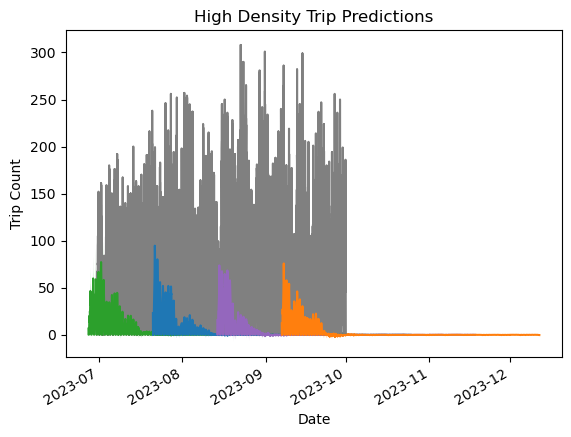

In [21]:
test_data_high_density['trip_count'].plot(color="grey")

for forecast, color in zip(forecasts, ["green"
                                       , "blue"
                                       , "purple"
                                       , "orange"
                                       #, "red"
                                       #, "cyan"
                                      ]):
    forecast.plot(color=f"tab:{color}")
    

plt.title("High Density Trip Predictions")
plt.xlabel('Date')
plt.ylabel('Trip Count')

# Saving the plot as a PNG file
plt.savefig('high_density_trip_predictions.png')

In [ ]:
# Ensure trip_start is datetime type
#test_data_high_density.loc[:, 'trip_start'] = pd.to_datetime(test_data_high_density['trip_start'])

# Resample trip_count to weekly values for test data
test_data_high_density_weekly = test_data_high_density.resample('D', on='trip_start').sum()
test_data_high_density_weekly['trip_count'] = test_data_high_density_weekly['trip_count'] / len(high_density_community)

# Plot the aggregated weekly trip counts
test_data_high_density_weekly['trip_count'].plot(color="grey", label="Actual Daily Trip Count")

# Resample forecasts to weekly values and plot them
for forecast, color in zip(forecasts, ["green", "blue", "purple"
                                       , "orange"
                                       #, "red", "cyan"
                                      ]):
    # Convert forecast samples to DataFrame
    forecast_df = pd.DataFrame(forecast.samples[0].T, index=pd.date_range(start=forecast.start_date.to_timestamp(), periods=len(forecast.samples[0]), freq='h'))
    # Resample to weekly values
    forecast_weekly = forecast_df.resample('D').sum()
    # Plot the mean of the forecast weekly values
    forecast_weekly_mean = forecast_weekly.mean(axis=1)
    forecast_weekly_mean.plot(color=f"tab:{color}", label=f"Forecast")


# Set plot title and labels
plt.title("High Density Trip Predictions (Daily Aggregation)")
plt.xlabel('Date')
plt.ylabel('Trip Count')
#plt.legend(loc='upper right', fontsize='small')

# Saving the plot as a PNG file
plt.savefig('high_density_trip_predictions_weekly.png')
plt.show()


In [ ]:
# Define a function to compute evaluation metrics
def compute_metrics(y_true, y_pred):
    metrics = {}
    metrics['MSE'] = mean_squared_error(y_true, y_pred)
    metrics['RMSE'] = np.sqrt(metrics['MSE'])
    metrics['MAE'] = mean_absolute_error(y_true, y_pred)
    
    # Handling division by zero in MAPE calculation
    nonzero_indices = y_true != 0
    if np.any(nonzero_indices):
        metrics['MAPE'] = np.mean(np.abs((y_true[nonzero_indices] - y_pred[nonzero_indices]) / y_true[nonzero_indices])) * 100
    else:
        metrics['MAPE'] = np.inf  # Assign a value for cases where all true values are zero
    
    return metrics

# Initialize dictionaries to store metrics for each community area
high_density_metrics = {community: {'MSE': [], 'RMSE': [], 'MAE': [], 'MAPE': []} for community in high_density_community}

# Iterate over forecasts and compute metrics for each community area
for forecast in forecasts:
    community = int(forecast.item_id)
    y_pred = forecast.samples.mean(axis=0)
    
    # Ensure the length of y_true matches the length of y_pred
    y_true = test_data_high_density[test_data_high_density['Start Community Area Number'] == community]['trip_count'].values[-len(y_pred):]
    
    # Truncate y_pred if it is longer than y_true
    if len(y_pred) > len(y_true):
        y_pred = y_pred[-len(y_true):]
    
    metrics = compute_metrics(y_true, y_pred)
    for key in metrics:
        high_density_metrics[community][key].append(metrics[key])

# Compute average metrics for high density areas
avg_high_density_metrics = {key: np.mean([np.mean(high_density_metrics[community][key]) for community in high_density_community]) for key in ['MSE', 'RMSE', 'MAE', 'MAPE']}

print("Average Metrics for High Density Areas:")
print(avg_high_density_metrics)

### Low Density Model

In [ ]:
# Train a DeepAR model on all data but the last 3 months
forecast_horizon = 96 * version_increment
num_static = static_df.shape[1]

training_data_low, test_gen_low = split(pd_dataset_low_density, offset = -forecast_horizon)

model_low = DeepAREstimator(
    prediction_length = forecast_horizon, 
    freq = "h", # Setting the time series granularity to daily
    trainer = Trainer(epochs = 50),
    #num_batches_per_epoch = 100, # Number of batches to be processed in each training epoch (default: 50).
    #num_cells = 50, # Num. of cells used in each hidden layer in RNN. Default value = 40.
    #num_layers = 4, # Num. of hidden layers in RNN. Default value = 2.
    #likelihood = 'negative-binomial'  # Used for count data. Options include gaussian, beta, negative-binomial, student-T (default), or deterministic-L1
).train(training_data_low)

### Export and Load Saved Model

import pickle

with open('gluonts_model', 'wb') as f:
    pickle.dump(predictor, f)

with open('gluonts_model', 'rb') as f:
    predictor = pickle.load(f)

In [ ]:
import pickle
from gluonts.model.predictor import Predictor

# Assuming `model_low` is your trained model

# Save the model to a file using pickle
with open('deepar_model_hourly_low_density.pkl', 'wb') as f:
    pickle.dump(model_low, f)

print("Model saved successfully.")

from gluonts.model.predictor import Predictor

# Load the model
predictor = Predictor.deserialize(save_dir)

### Predicting Low Density Model

In [ ]:
future_horizon = 24 * version_increment
windows_num = forecast_horizon / future_horizon

# Generate test instances and predictions for them
test_data_low = test_gen_low.generate_instances(prediction_length = future_horizon, windows = 4)
forecasts_low = list(model_low.predict(test_data_low.input))

In [ ]:
test_data_low_density['trip_count'].plot(color="grey")

for forecast, color in zip(forecasts_low, ["green"
                                       , "blue"
                                       , "purple"
                                       , "orange"
                                       #, "red"
                                       #, "cyan"
                                      ]):
    forecast.plot(color=f"tab:{color}")
    

plt.title("Low Density Trip Predictions")
plt.xlabel('Date')
plt.ylabel('Trip Count')

# Saving the plot as a PNG file
plt.savefig('low_density_trip_predictions.png')

In [ ]:
len(low_density_community)

In [ ]:
# Ensure trip_start is datetime type
#test_data_low_density.loc[:, 'trip_start'] = pd.to_datetime(test_data_low_density['trip_start'])

# Resample trip_count to weekly values for test data
test_data_low_density_weekly = test_data_low_density.resample('D', on='trip_start').sum()
test_data_low_density_weekly['trip_count'] = test_data_low_density_weekly['trip_count'] / len(low_density_community)

# Plot the aggregated weekly trip counts
test_data_low_density_weekly['trip_count'].plot(color="grey", label="Actual Daily Trip Count")


# Resample forecasts to weekly values and plot them
for forecast, color in zip(forecasts_low, ["green", "blue", "purple"
                                       , "orange"
                                       #, "red", "cyan"
                                      ]):
    # Convert forecast samples to DataFrame
    forecast_df = pd.DataFrame(forecast.samples[0].T, index=pd.date_range(start=forecast.start_date.to_timestamp(), periods=len(forecast.samples[0]), freq='h'))
    # Resample to weekly values
    forecast_weekly = forecast_df.resample('D').sum()
    # Plot the mean of the forecast weekly values
    forecast_weekly_mean = forecast_weekly.mean(axis=1)
    forecast_weekly_mean.plot(color=f"tab:{color}", label=f"Forecast")


# Set plot title and labels
plt.title("Low Density Trip Predictions (Daily Aggregation)")
plt.xlabel('Date')
plt.ylabel('Trip Count')
plt.legend(loc='upper right', fontsize='small')

# Saving the plot as a PNG file
plt.savefig('low_density_trip_predictions_weekly.png')
plt.show()


## Calculation Evaluation Criteria

In [ ]:
# Define a function to compute evaluation metrics
def compute_metrics(y_true, y_pred):
    metrics = {}
    metrics['MSE'] = mean_squared_error(y_true, y_pred)
    metrics['RMSE'] = np.sqrt(metrics['MSE'])
    metrics['MAE'] = mean_absolute_error(y_true, y_pred)
    
    # Handling division by zero in MAPE calculation
    nonzero_indices = y_true != 0
    if np.any(nonzero_indices):
        metrics['MAPE'] = np.mean(np.abs((y_true[nonzero_indices] - y_pred[nonzero_indices]) / y_true[nonzero_indices])) * 100
    else:
        metrics['MAPE'] = np.inf  # Assign a value for cases where all true values are zero
    
    return metrics

# Initialize dictionaries to store metrics for each community area
high_density_metrics = {community: {'MSE': [], 'RMSE': [], 'MAE': [], 'MAPE': []} for community in high_density_community}
low_density_metrics = {community: {'MSE': [], 'RMSE': [], 'MAE': [], 'MAPE': []} for community in low_density_community}


# Iterate over forecasts and compute metrics for each community area
for forecast in forecasts:
    community = int(forecast.item_id)
    y_pred = forecast.samples.mean(axis=0)
    
    # Ensure the length of y_true matches the length of y_pred
    y_true = test_data_high_density[test_data_high_density['Start Community Area Number'] == community]['trip_count'].values[-len(y_pred):]
    
    # Truncate y_pred if it is longer than y_true
    if len(y_pred) > len(y_true):
        y_pred = y_pred[-len(y_true):]
    
    metrics = compute_metrics(y_true, y_pred)
    for key in metrics:
        high_density_metrics[community][key].append(metrics[key])

for forecast in forecasts_low:
    community = int(forecast.item_id)
    y_pred = forecast.samples.mean(axis=0)
    
    # Ensure the length of y_true matches the length of y_pred
    y_true = test_data_low_density[test_data_low_density['Start Community Area Number'] == community]['trip_count'].values[-len(y_pred):]
    
    # Truncate y_pred if it is longer than y_true
    if len(y_pred) > len(y_true):
        y_pred = y_pred[-len(y_true):]
    
    metrics = compute_metrics(y_true, y_pred)
    for key in metrics:
        low_density_metrics[community][key].append(metrics[key])


# Compute average metrics for high density areas
avg_high_density_metrics = {key: np.mean([np.mean(high_density_metrics[community][key]) for community in high_density_community]) for key in ['MSE', 'RMSE', 'MAE', 'MAPE']}
avg_low_density_metrics = {key: np.mean([np.mean(low_density_metrics[community][key]) for community in low_density_community]) for key in ['MSE', 'RMSE', 'MAE', 'MAPE']}

print("Average Metrics for High Density Areas:")
print(avg_high_density_metrics)

print("Average Metrics for Low Density Areas:")
print(avg_low_density_metrics)

### Old Metrics

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Define a function to compute evaluation metrics
def compute_metrics(y_true, y_pred):
    metrics = {}
    metrics['MSE'] = mean_squared_error(y_true, y_pred)
    metrics['RMSE'] = np.sqrt(metrics['MSE'])
    metrics['MAE'] = mean_absolute_error(y_true, y_pred)
    
    # Handling division by zero in MAPE calculation
    nonzero_indices = y_true != 0
    if np.any(nonzero_indices):
        metrics['MAPE'] = np.mean(np.abs((y_true[nonzero_indices] - y_pred[nonzero_indices]) / y_true[nonzero_indices])) * 100
    else:
        metrics['MAPE'] = np.inf  # Assign a value for cases where all true values are zero
    
    return metrics

# Initialize dictionaries to store metrics for each community area
high_density_metrics = {community: {'MSE': [], 'RMSE': [], 'MAE': [], 'MAPE': []} for community in high_density_community}
low_density_metrics = {community: {'MSE': [], 'RMSE': [], 'MAE': [], 'MAPE': []} for community in low_density_community}

# Iterate over forecasts and compute metrics for each community area
for forecast in forecasts:
    community = int(forecast.item_id)
    y_pred = forecast.samples.mean(axis=0)
    y_true = test_data_high_density[test_data_high_density['Start Community Area Number'] == community]['trip_count'].values[-forecast_horizon:]
    metrics = compute_metrics(y_true, y_pred)
    for key in metrics:
        high_density_metrics[community][key].append(metrics[key])

for forecast in forecasts_low:
    community = int(forecast.item_id)
    y_pred = forecast.samples.mean(axis=0)
    y_true = test_data_low_density[test_data_low_density['Start Community Area Number'] == community]['trip_count'].values[-forecast_horizon:]
    metrics = compute_metrics(y_true, y_pred)
    for key in metrics:
        low_density_metrics[community][key].append(metrics[key])

# Compute average metrics for high density and low density areas
avg_high_density_metrics = {key: np.mean([np.mean(high_density_metrics[community][key]) for community in high_density_community]) for key in ['MSE', 'RMSE', 'MAE', 'MAPE']}
avg_low_density_metrics = {key: np.mean([np.mean(low_density_metrics[community][key]) for community in low_density_community]) for key in ['MSE', 'RMSE', 'MAE', 'MAPE']}

print("Average Metrics for High Density Areas:")
print(avg_high_density_metrics)

print("Average Metrics for Low Density Areas:")
print(avg_low_density_metrics)
